In [0]:
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future


import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam

import keras.backend as K
if len(K.tensorflow_backend._get_available_gpus()) > 0:
  from keras.layers import CuDNNLSTM as LSTM
  from keras.layers import CuDNNGRU as GRU




# Hyper Parameters
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 20
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 30
NUM_SAMPLES = 10000



# Where we will store the data
input_texts = [] # sentence in original language
target_texts = [] # sentence in target language



# load data


In [8]:
# download the data at: http://www.manythings.org/anki/
t = 0
for line in open('pes.txt'):
  # only keep a limited number of samples
  t += 1
  if t > NUM_SAMPLES:
    break

  # input and target are separated by tab
  if '\t' not in line:
    continue

  # split up the input and translation
  input_text, translation = line.rstrip().split('\t')

  input_texts.append(input_text)
  target_texts.append(translation)
print("num samples:", len(input_texts))



num samples: 1954


## Preprocessing

In [9]:

tokenizer_inputs = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

# get the word to index mapping for input language
word2idx_inputs = tokenizer_inputs.word_index
print('Found %s unique input tokens.' % len(word2idx_inputs))
num_words_input = len(word2idx_inputs) + 1

# determine maximum length input sequence
max_len_input = max(len(s) for s in input_sequences)

# tokenize the outputs
# don't filter out special characters
# otherwise <sos> and <eos> won't appear
tokenizer_outputs = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='')
tokenizer_outputs.fit_on_texts(target_texts)
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)

# get the word to index mapping for output language
word2idx_outputs = tokenizer_outputs.word_index
print('Found %s unique output tokens.' % len(word2idx_outputs))

# store number of output words for later
# remember to add 1 since indexing starts at 1
num_words_output = len(word2idx_outputs) + 1

# determine maximum length output sequence
max_len_target = max(len(s) for s in target_sequences)


max_len_both = max(max_len_input, max_len_target)



# pad the sequences
inputs_padded = pad_sequences(input_sequences, maxlen=max_len_both)
targets_padded = pad_sequences(target_sequences, maxlen=max_len_both)



# create targets, since we cannot use sparse
# categorical cross entropy when we have sequences
targets_padded_one_hot = np.zeros(
  (
    len(targets_padded),
    max_len_both,
    num_words_output
  ),
  dtype='float32'
)

# assign the values
for i, d in enumerate(targets_padded):
  for t, word in enumerate(d):
    targets_padded_one_hot[i, t, word] = 1




Found 2260 unique input tokens.
Found 3479 unique output tokens.


# Create Mode

Training model...
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 1563 samples, validate on 391 samples
Epoch 1/30
1563/1563 [==============================] - 11s 7ms/step - loss: 3.1795 - acc: 0.7213 - val_loss: 3.6740 - val_acc: 0.6168
Epoch 2/30
1563/1563 [==============================] - 9s 6ms/step - loss: 1.6971 - acc: 0.7861 - val_loss: 3.1074 - val_acc: 0.6111
Epoch 3/30
1563/1563 [==============================] - 9s 6ms/step - loss: 1.5415 - acc: 0.7878 - val_loss: 3.0859 - val_acc: 0.6179
Epoch 4/30
1563/1563 [==============================] - 9s 6ms/step - loss: 1.4633 - acc: 0.7896 - val_loss: 3.1235 - val_acc: 0.6159
Epoch 5/30
1563/1563 [==============================] - 9s 6ms/step - loss: 1.4139 - acc: 0.7910 - val_loss: 3.1556 - val_acc: 0.6167
Epoch 6/30
1563/1563 [==============================] - 9s 6ms/step - loss: 1.3700 - acc: 0.7920 - val_loss: 3.1872 - val_acc: 0.6181
Epoch 7/30
1563/1563 [==============================

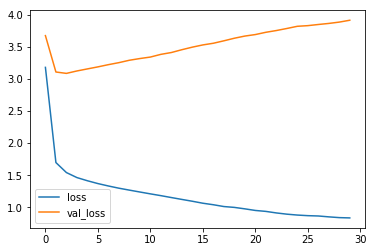

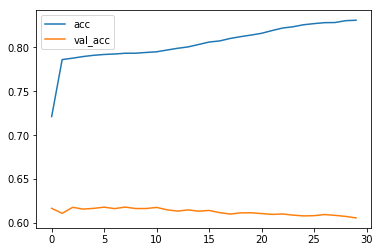

In [10]:
# create an LSTM network with a single LSTM
input_ = Input(shape=(max_len_both,))
x = Embedding(num_words_input, EMBEDDING_DIM)(input_)
x = Bidirectional(LSTM(15, return_sequences=True))(x)
output = Dense(num_words_output, activation='softmax')(x)

model = Model(input_, output)
model.compile(
  loss='categorical_crossentropy',
  optimizer=Adam(lr=0.1),
  metrics=['accuracy']
)


print('Training model...')
r = model.fit(
  inputs_padded,
  targets_padded_one_hot,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()